In [5]:
import atlite
import geopandas as gpd

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os
from matplotlib.gridspec import GridSpec
#import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr

import logging
import warnings

import numpy as np

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [6]:
dirname = os.getcwd()

#load geodata
model_regions_file = os.path.join(dirname,'input_data',"BALMOREL_model_regions_GADM.geojson")
model_regions = gpd.read_file(model_regions_file).set_index("model_reg")

model_areas_file = os.path.join(dirname,'input_data',"ADM1_GADM.geojson")
model_areas = gpd.read_file(model_areas_file).set_index("NAME_1")

country_file = os.path.join(dirname,'input_data',"EG_adm0.geojson")
country = gpd.read_file(country_file).set_index("COUNTRY")


In [7]:
#load cutout 
cutout = atlite.Cutout(os.path.join(dirname,'input_data',"egypt-2015-wind-era5.nc"))

#access cutout data
cutout.data

<xarray.Dataset> Size: 198MB
Dimensions:      (x: 47, y: 40, time: 8760)
Coordinates:
  * x            (x) float64 376B 24.75 25.0 25.25 25.5 ... 35.75 36.0 36.25
  * y            (y) float64 320B 21.75 22.0 22.25 22.5 ... 31.0 31.25 31.5
  * time         (time) datetime64[ns] 70kB 2015-01-01 ... 2015-12-31T23:00:00
    lon          (x) float64 376B dask.array<chunksize=(47,), meta=np.ndarray>
    lat          (y) float64 320B dask.array<chunksize=(40,), meta=np.ndarray>
Data variables:
    wnd100m      (time, y, x) float32 66MB dask.array<chunksize=(100, 40, 47), meta=np.ndarray>
    wnd_azimuth  (time, y, x) float32 66MB dask.array<chunksize=(100, 40, 47), meta=np.ndarray>
    roughness    (time, y, x) float32 66MB dask.array<chunksize=(100, 40, 47), meta=np.ndarray>
Attributes:
    module:                  era5
    prepared_features:       wind
    chunksize_time:          100
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-02T10:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
#get max wind speed over all dimensions
cutout.data['wnd100m'].max().compute()

<xarray.DataArray 'wnd100m' ()> Size: 4B
array(22.529976, dtype=float32)

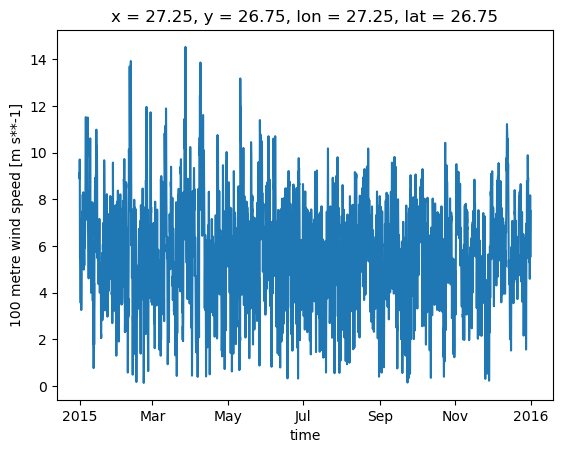

In [9]:
#access the wind speed data of a certain pixel
wind_pixel = cutout.data['wnd100m'].isel(x=10, y=20)
# Plot the wind speed over time
wind_pixel.plot.line()

In [10]:
#standards for all plots
projection = ccrs.Orthographic(central_longitude=30, central_latitude=30)
cells = cutout.grid
cutout_bound = gpd.GeoSeries(cells.unary_union)

Text(0.5, 1.0, 'mean windspeed over the whole country')

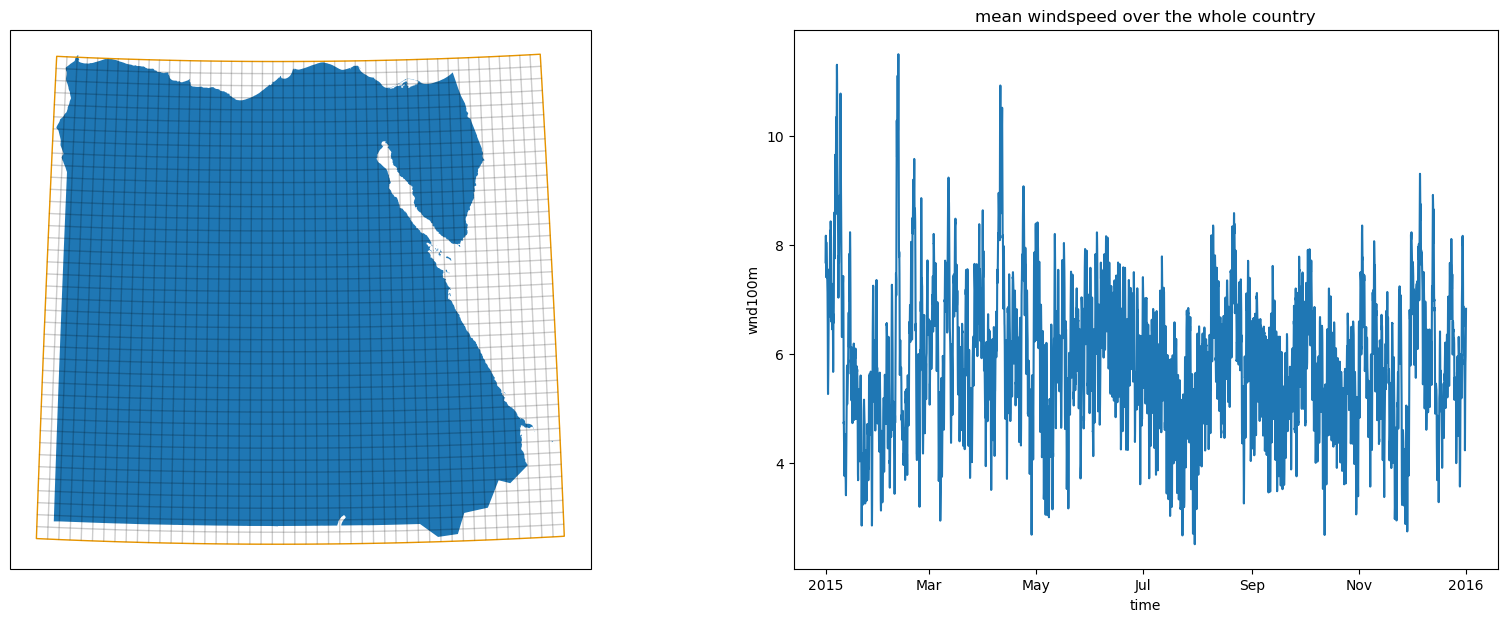

In [11]:
#plot country and mean windspeed for overview
#cartopy approach --> projections and transformation
fig = plt.figure(figsize=(20, 7))
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
country.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
cutout_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 1])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_title('mean windspeed over the whole country')
#ax1.set_frame_on(False)
#ax1.xaxis.set_visible(False)

In [12]:
#interactive plot mean wind speed over whole year for each pixel
wnd100m = cutout.data.wnd100m.mean(dim="time")

quadmesh_plot = wnd100m.hvplot.quadmesh(
    "x",
    "y",
    "wnd100m",
    frame_height=500,
    cmap="viridis",
    geo=True,
    tiles="CartoLight",
    alpha=0.8,
    padding=0.5,
    clim=(0, 10),
    title='mean windspeed @100m',
    hover_cols=['x', 'y', 'wnd100m'],  # Include x, y, and wind speed in hover
)

polygon_plot = model_regions.hvplot(
    geo=True,
    line_color='red',        # Set color of polygons, e.g., red
    fill_alpha=0,          # Transparency level of polygons
    line_width=1.5,     # Line width for borders of polygons
)

# Overlaying the quadmesh plot with the polygon plot
overlay = quadmesh_plot * polygon_plot

# Display the final overlay plot
overlay

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .QuadMesh.I :QuadMesh   [x,y]   (wnd100m,x,y,wnd100m)
   .Polygons.I :Polygons   [Longitude,Latitude]

<GeoAxes: xlabel='x', ylabel='y'>

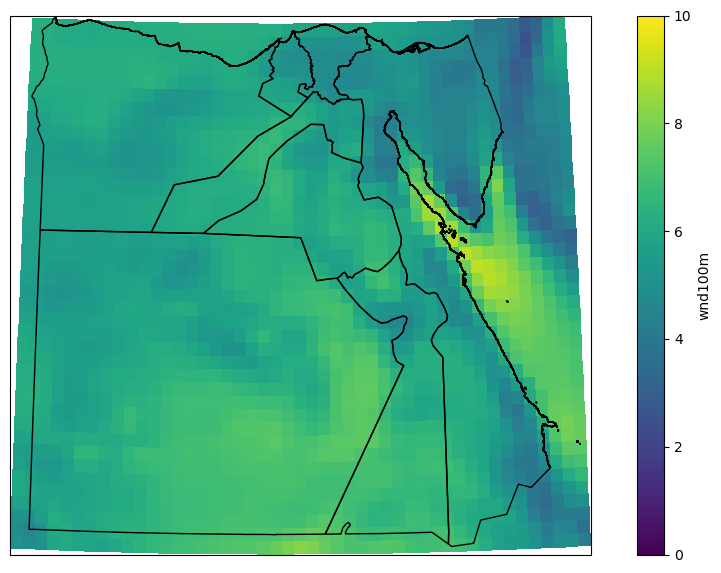

In [13]:
#static plot
fig = plt.figure(figsize=(12, 7))

ax = plt.axes(projection=projection)
wnd100m.plot(ax=ax, vmin=0, vmax=10, transform=plate())

#shape.to_crs(crs).plot(ax=ax, edgecolor="k", color="None")
model_regions.to_crs(projection.proj4_init).plot(ax=ax, edgecolor="k", color="None")
#shape.plot(ax=ax, edgecolor="k", color="None", transform=plate())

#ax.set_extent([70, 75, 18, 25], crs=crs)

#import cartopy
#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#ax.add_feature(cartopy.feature.LAND, color="cornsilk")
#ax.add_feature(cartopy.feature.OCEAN, color="azure")


# aggregate wind speed timeseries per model area

In [20]:
#check data structure of wind turbine to define helper turbine
atlite.resource.get_windturbineconfig('NREL_ReferenceTurbine_5MW_offshore')

{'V': array([ 0,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 25, 25]),
 'POW': array([0.    , 0.    , 0.0405, 0.1777, 0.4039, 0.7376, 1.1872, 1.7711,
        2.5186, 3.4484, 4.5625, 5.    , 5.    , 0.    ]),
 'hub_height': 90.0,
 'P': 5.0}

In [24]:
#create helper power curve where wind speeds are mapped to themselves 
wind_speed = np.arange(0, 31, 1)
wind_speed_power = wind_speed
helper_turbine = {'hub_height':100, 'V':wind_speed, 'POW':wind_speed_power, 'P':5}

In [25]:
#check helper turbine
atlite.resource.get_windturbineconfig(helper_turbine)

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


{'hub_height': 100,
 'V': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'POW': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'P': 5}

In [26]:
windspeed_aggregated_areas = cutout.wind(helper_turbine, shapes=model_areas.geometry)

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


In [27]:
result = windspeed_aggregated_areas.to_pandas().rename_axis(index="", columns="shapes")
result

shapes,Ad Daqahliyah,Al Bahr al Ahmar,Al Buhayrah,Al Fayyum,Al Gharbiyah,Al Iskandariyah,Al Isma`iliyah,Al Jizah,Al Minufiyah,Al Minya,...,Asyut,Bani Suwayf,Bur Sa`id,Dumyat,Janub Sina',Kafr ash Shaykh,Matrouh,Qina,Shamal Sina',Suhaj
,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8.984150,116.534065,34.776262,16.881726,4.989565,8.108624,11.291800,105.384530,5.946994,85.994534,...,37.200270,25.535726,3.053783,2.344870,25.256711,10.624496,517.189298,12.023895,23.021910,22.574888
2015-01-01 01:00:00,9.561415,112.084137,34.770441,16.898467,5.265448,7.999865,12.982849,102.498879,6.256171,87.428552,...,41.359208,25.927974,3.519843,2.592980,25.743313,11.196476,513.719850,16.966154,27.459251,24.328133
2015-01-01 02:00:00,9.825187,111.242802,33.423796,16.149223,5.256976,7.685578,14.486412,101.775769,6.101104,87.238669,...,45.991176,25.344118,3.905601,2.757420,29.837372,11.234592,509.068865,20.016981,33.477324,26.403242
2015-01-01 03:00:00,9.526861,113.363769,33.129435,14.914057,5.080987,7.699528,14.230534,102.391047,5.847679,85.114319,...,48.426490,23.464973,3.971597,2.740343,37.721276,10.966356,492.607242,22.010901,40.978620,29.313917
2015-01-01 04:00:00,9.594168,115.657340,33.232063,14.950277,5.195772,7.639306,13.449048,101.492568,5.982741,85.074263,...,47.885930,22.720987,3.933026,2.736991,44.209863,11.155418,469.816807,24.210611,47.302506,30.668176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,7.684143,190.491480,21.310167,11.175640,3.480514,5.973304,12.248520,78.532202,3.352776,60.680981,...,29.847710,19.618688,3.519260,2.586666,41.038379,9.698375,347.963114,22.338685,58.886868,15.666265
2015-12-31 20:00:00,8.303858,199.336352,22.526697,10.313634,3.729993,6.379663,12.522646,76.892262,3.592918,63.497964,...,32.139017,18.634051,3.769544,2.814400,45.324588,9.901339,341.949968,22.224447,64.795289,16.359637
2015-12-31 21:00:00,8.558798,204.038062,23.412804,9.954529,3.786470,6.488520,12.352221,76.671272,3.786841,64.810243,...,33.608862,17.638852,4.032115,2.887076,48.951471,10.099043,332.625032,21.087522,69.895096,17.430293


<Axes: >

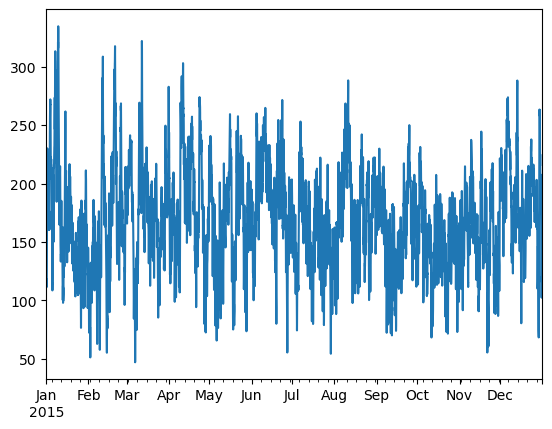

In [28]:
result['Al Bahr al Ahmar'].plot()